# <center>ASL Recognition Model</center>

### Initialization

In [ ]:
import zipfile

# install splitfolder module
! pip install split-folders

# delete the folder named 'kaggle' if it exists
! rm -r /root/.kaggle
! rm -r /content/sample_data
! rm -r /content/dataset
! rm -r /content/split_dataset

# give permissions to kaggle API
! pip install kaggle
! mkdir /root/.kaggle
! cp kaggle.json /root/.kaggle
! chmod 600 /root/.kaggle/kaggle.json

rm: cannot remove '/content/sample_data': No such file or directory
rm: cannot remove '/content/dataset': No such file or directory
rm: cannot remove '/content/split_dataset': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# download dataset from kaggle to colab
! kaggle datasets download -d grassknoted/asl-alphabet

# extract the content of the zipped file
zip_ref = zipfile.ZipFile('asl-alphabet.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
# rename the folder from 'American' to 'dataset' for ease of use
! rm -r /content/asl-alphabet.zip
! rm -r /content/kaggle.json

rm: cannot remove '/content/kaggle.json': No such file or directory


### Modules & Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, BatchNormalization, Activation

import os
import cv2
import glob
import pickle
import random
import warnings
import splitfolders
from google.colab import drive
from google.colab import files


drive.mount('/content/gdrive')
warnings.filterwarnings('ignore')
%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Exploratory Data Analysis

In [ ]:
batch_size = 64
img_height = 64
img_width = 64
epochs = 30
num_classes = 27
img_channels = 3

In [ ]:
# Define the path to the main folder

! rm -r /content/asl_alphabet_train/asl_alphabet_train/del
! rm -r /content/asl_alphabet_train/asl_alphabet_train/nothing

main_folder_path = '/content/asl_alphabet_train/asl_alphabet_train/'


# Get a list of subfolders within the main folder
subfolders = os.listdir(main_folder_path)

#### Visualization of image from each class

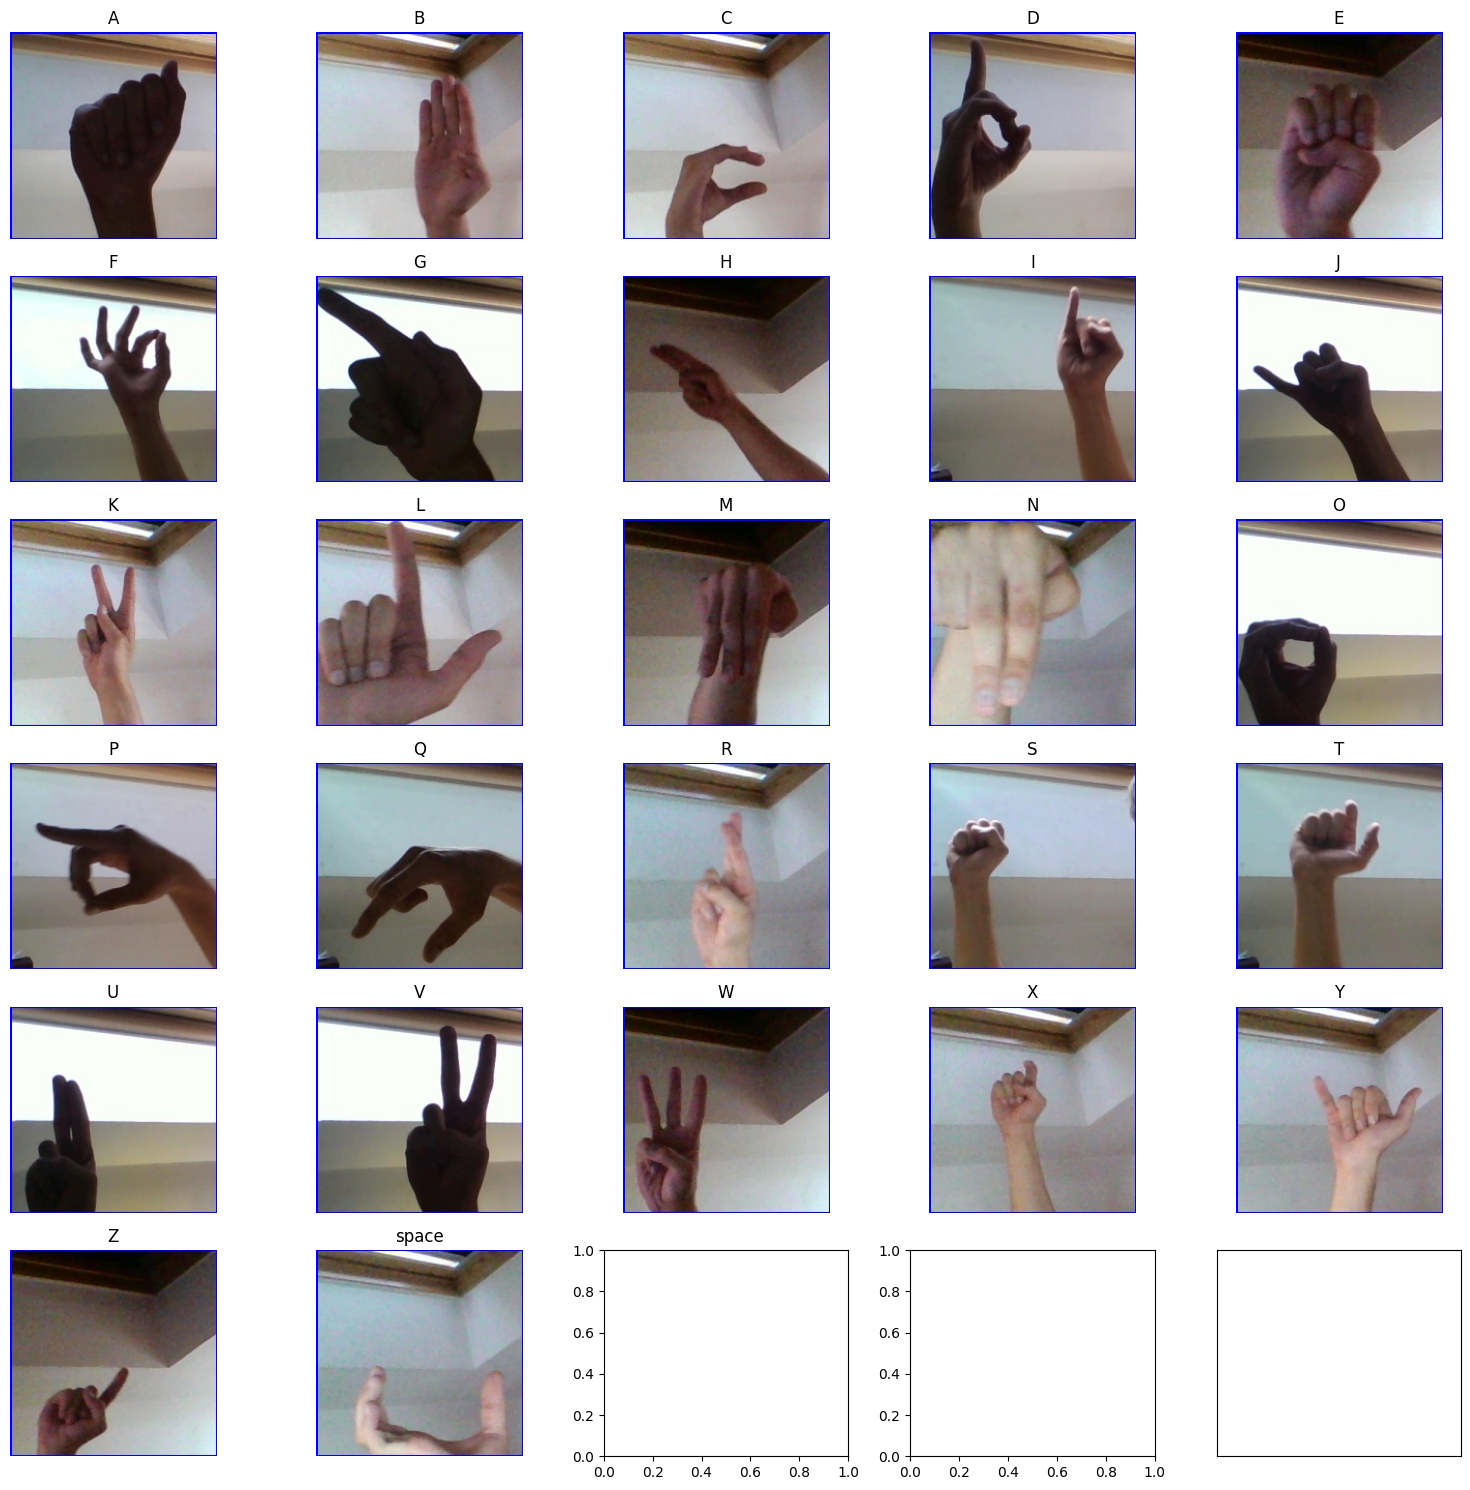

In [ ]:
categories = {}
label = []
count = []

# Create a figure to display the images
rows = 6
columns = 5
fig, axs = plt.subplots(rows, columns, figsize=(15, 15))
ax = axs.ravel()

# Iterate through each subfolder and display the first image
for index, subfolder in enumerate(sorted(subfolders)):
    plt.xticks([])
    plt.yticks([])

    categories[index] = subfolder

    # print('subfolder', subfolder, i)
    subfolder_path = os.path.join(main_folder_path, subfolder)
    image_files = os.listdir(subfolder_path)

    count.append(len(image_files))
    label.append(subfolder)

    # Load the first image in the subfolder
    image_path = os.path.join(subfolder_path, image_files[0])
    img = mimg.imread(image_path)

    # Display the image using plt.imshow
    ax[index].imshow(img)
    ax[index].set_title(subfolder)
    ax[index].axis('off')



# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

df = pd.DataFrame({'Label': label, 'Count': count})

#### Visualization of number of images in each class

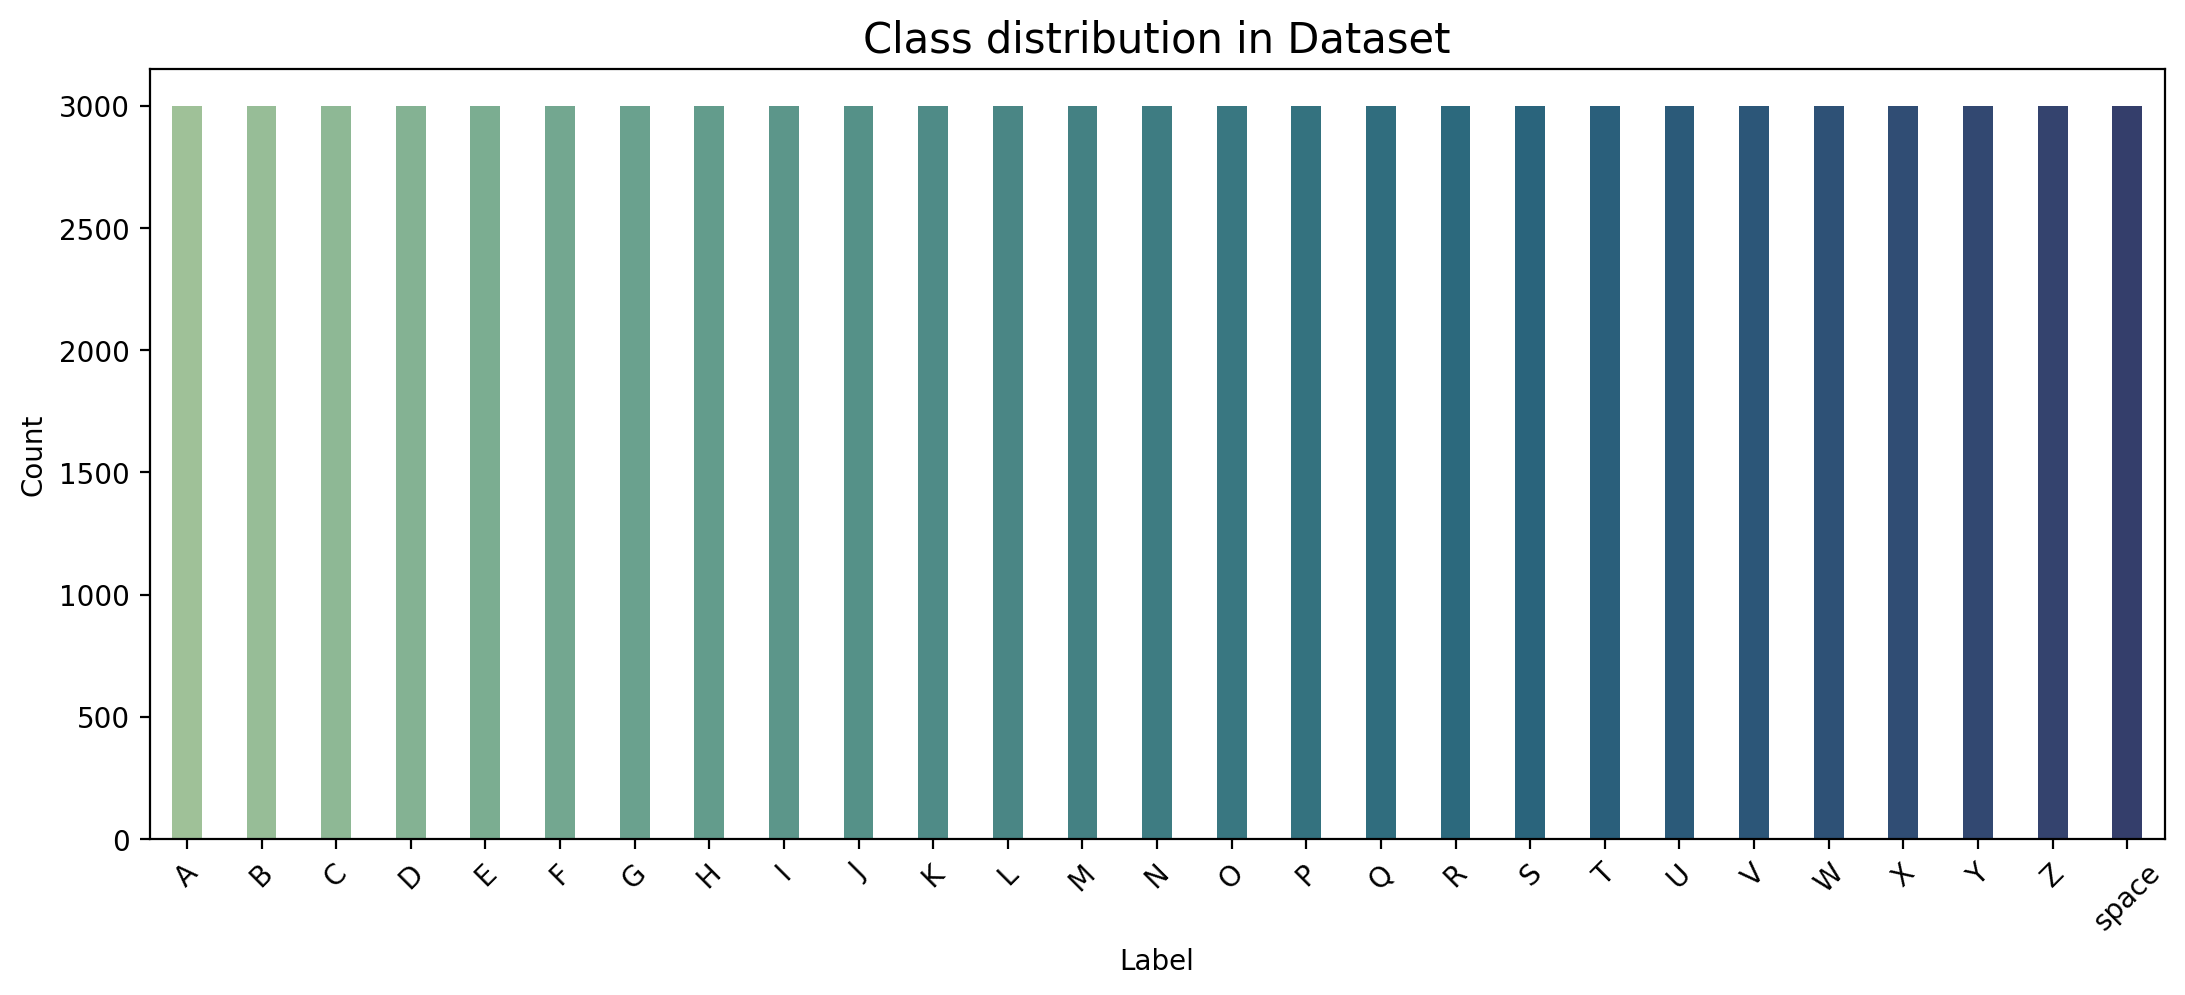

In [ ]:
plt.figure(figsize=(13, 5), dpi=200)
plt.title('Class distribution in Dataset',fontsize=15)

sns.barplot(data=df, x='Label', y='Count', width=0.4, palette='crest')

plt.xticks(rotation = 45)
plt.show()

In [ ]:
df['Count'].min(), df['Count'].max()

(3000, 3000)

Since there are 3000 images in each clas, we can conclude that the dataset is balanced.

In [ ]:
categories

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z',
 26: 'space'}

#### Distribution of dimension of the images

In [ ]:
width_dim = []
height_dim = []

def get_dimension():
    sub_dataset_path = f'/content/asl_alphabet_train/asl_alphabet_train'
    letters = os.listdir(sub_dataset_path)

    for letter in letters:
        letter_path = os.path.join(sub_dataset_path, letter)

        for image in os.listdir(letter_path):

            image_path = os.path.join(letter_path, image)
            img = mimg.imread(image_path)
            d1, d2, colors = img.shape

            width_dim.append(d1)
            height_dim.append(d2)

get_dimension()

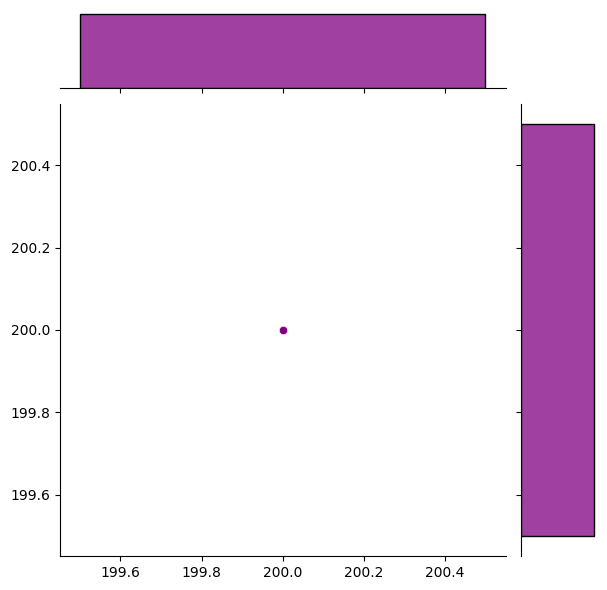

In [ ]:
sns.jointplot(x=width_dim, y=height_dim, color='purple')
plt.show()

In [ ]:
stats.mode(width_dim), stats.mode(height_dim), 3

(ModeResult(mode=200, count=81000), ModeResult(mode=200, count=81000), 3)

The dimension of each image in the dataset is 200x200.

In [ ]:
image_shape = 3
200*200*3

120000

### Data Preprocessing

In [ ]:
# Create dataframe
labels = list(categories.values())

list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(main_folder_path, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)


    list_path.extend(image_files)
    list_labels.extend(sign_label)

dataframe = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

# dataframe

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dataframe["image_path"],
    dataframe["label"],
    test_size=0.15,
    random_state=2023,
    shuffle=True,
    stratify = dataframe["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    train_df["image_path"], train_df["label"],
    test_size=0.20,
    random_state=2023,
    shuffle=True,
    stratify=train_df["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
val_df = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
test_df = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

In [ ]:
datagen = image.ImageDataGenerator(rescale=1/255.,)
                            #  rotation_range=20,
                            #   shear_range=0.2,
                            #   zoom_range=0.2,
                            #   horizontal_flip=True)
# Training Dataset
train_gen = datagen.flow_from_dataframe(
    train_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    batch_size=batch_size,
    target_size=(img_height, img_width),
)

# Validation Dataset
val_gen = datagen.flow_from_dataframe(
    val_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    batch_size=batch_size,
    target_size=(img_height, img_width),
)

# Testing Dataset
test_gen = datagen.flow_from_dataframe(
    test_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    batch_size=1,
    target_size=(img_height, img_width),
    shuffle=False
)

Found 55080 validated image filenames belonging to 27 classes.
Found 13770 validated image filenames belonging to 27 classes.
Found 12150 validated image filenames belonging to 27 classes.


### Model Training

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

None

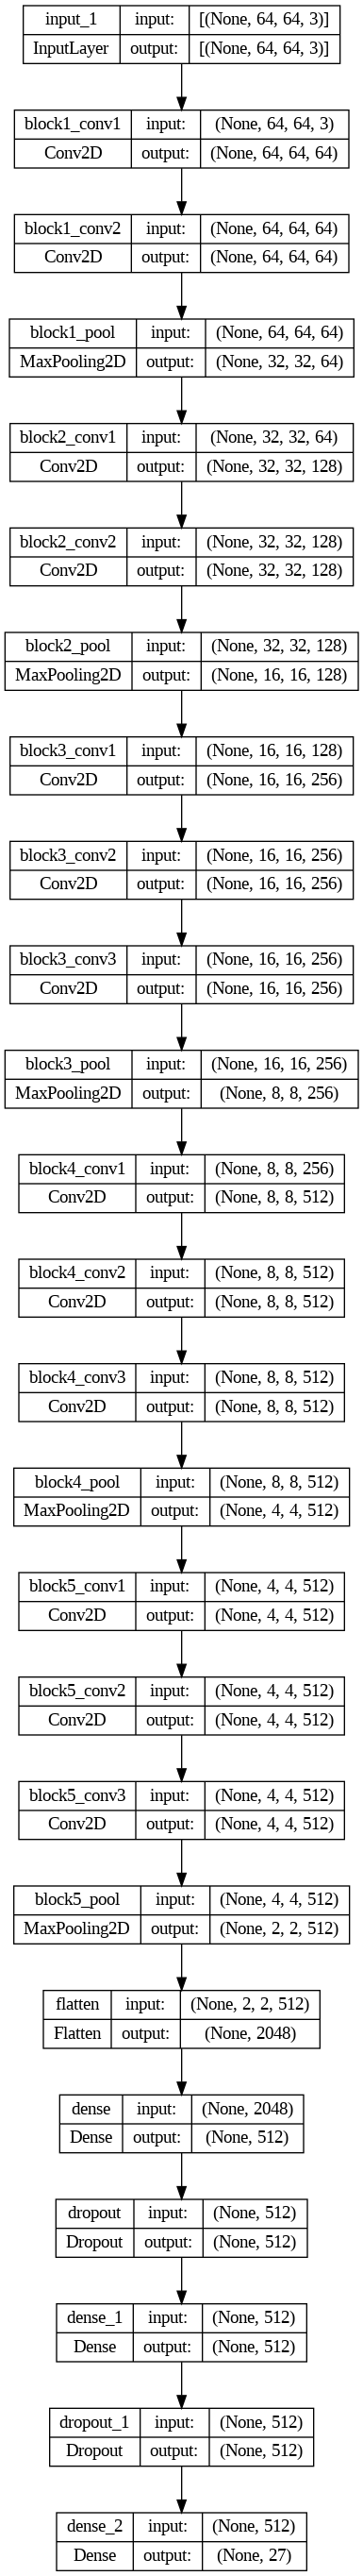

In [ ]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(27, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5,
                              restore_best_weights=True,
                              verbose=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        factor=0.5,
                                        verbose=True)

In [ ]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
# Train the Model
model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

Epoch 1/30
860/860 [==============================] - 77s 82ms/step - loss: 1.0955 - accuracy: 0.6541 - val_loss: 0.2317 - val_accuracy: 0.9353 - lr: 0.0010
Epoch 2/30
860/860 [==============================] - 94s 109ms/step - loss: 0.3917 - accuracy: 0.8666 - val_loss: 0.1226 - val_accuracy: 0.9639 - lr: 0.0010
Epoch 3/30
860/860 [==============================] - 66s 77ms/step - loss: 0.2838 - accuracy: 0.9024 - val_loss: 0.0923 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 4/30
860/860 [==============================] - 80s 93ms/step - loss: 0.2440 - accuracy: 0.9171 - val_loss: 0.0801 - val_accuracy: 0.9743 - lr: 0.0010
Epoch 5/30
860/860 [==============================] - 69s 80ms/step - loss: 0.2250 - accuracy: 0.9237 - val_loss: 0.0666 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 6/30
860/860 [==============================] - 68s 79ms/step - loss: 0.1976 - accuracy: 0.9324 - val_loss: 0.0398 - val_accuracy: 0.9885 - lr: 0.0010
Epoch 7/30
860/860 [==============================] - 67s

## Model Evaluation

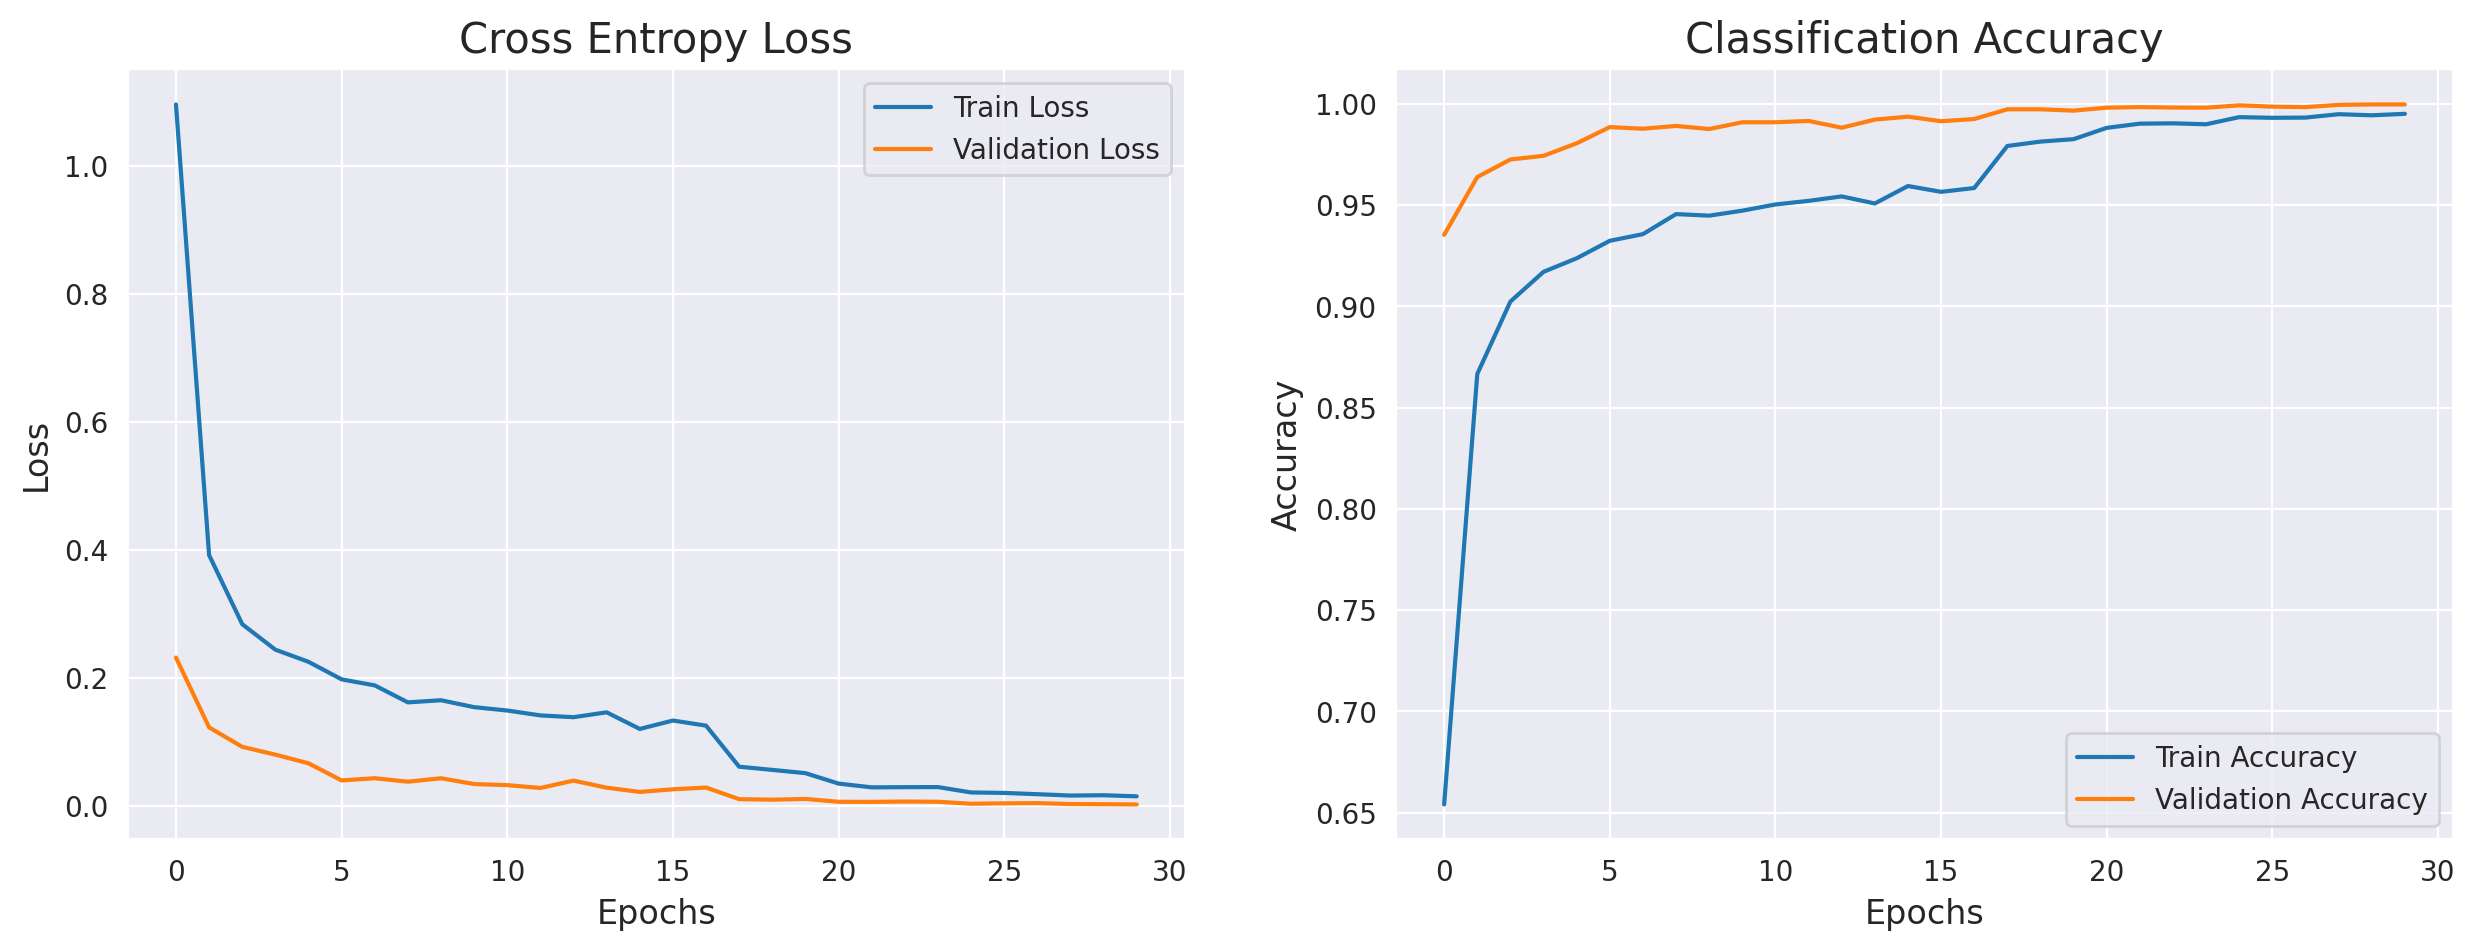

In [ ]:
metrics = pd.DataFrame(model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate test dataset
loss, acc = model.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

The accuracy of the model for testing data is: 99.96708035469055
The Loss of the model for testing data is: 0.002332584699615836


In [ ]:
predicted_class = model.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

Correct predicted classes: 12146
Incorrect predicted classes: 4


In [ ]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       450
           B       1.00      1.00      1.00       450
           C       1.00      1.00      1.00       450
           D       1.00      1.00      1.00       450
           E       1.00      1.00      1.00       450
           F       1.00      1.00      1.00       450
           G       1.00      1.00      1.00       450
           H       1.00      1.00      1.00       450
           I       1.00      1.00      1.00       450
           J       1.00      1.00      1.00       450
           K       1.00      1.00      1.00       450
           L       1.00      1.00      1.00       450
           M       1.00      1.00      1.00       450
           N       1.00      1.00      1.00       450
           O       1.00      1.00      1.00       450
           P       1.00      1.00      1.00       450
           Q       1.00      1.00      1.00       450
           R       1.00    

In [ ]:
con_matrix = tf.math.confusion_matrix(
        labels=actual_class,
        predictions=predicted_class,
        num_classes=27)

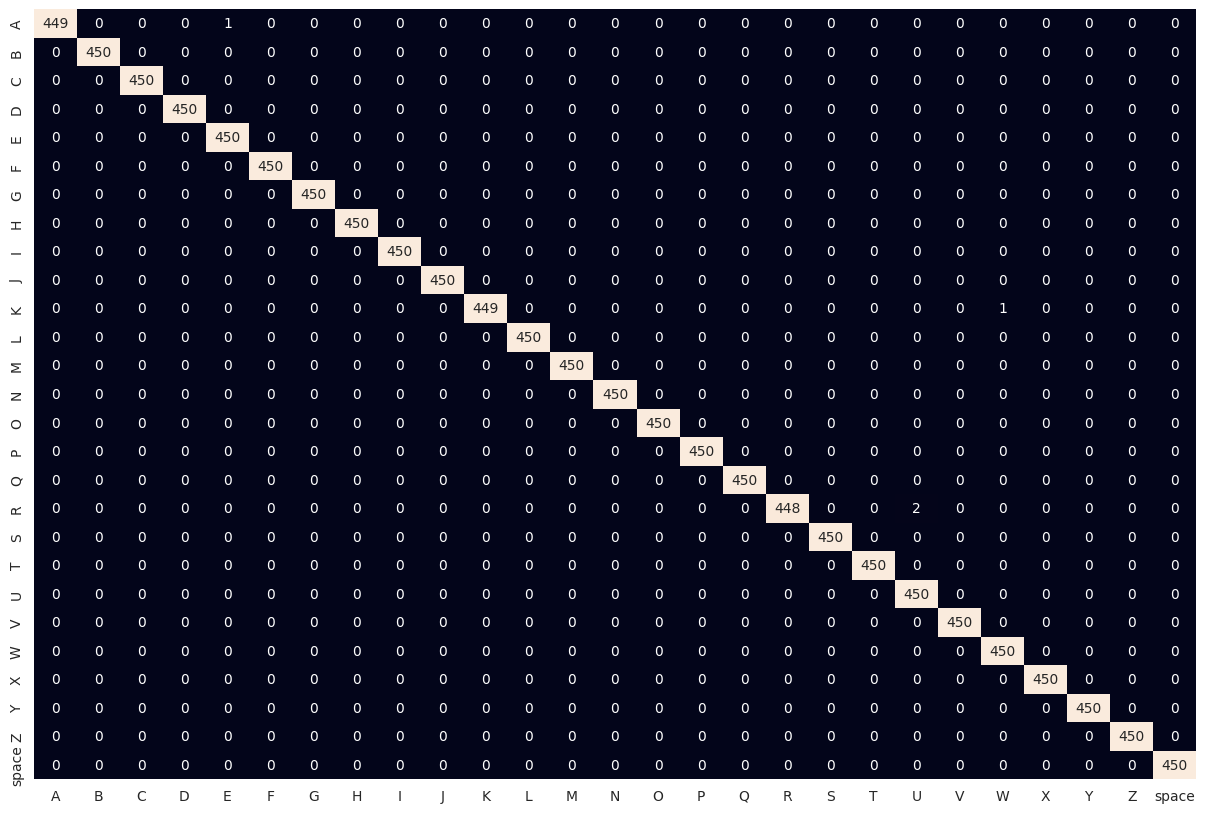

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(con_matrix, annot=True, fmt='g', cbar=False, xticklabels=categories.values(), yticklabels=categories.values())
plt.show()

In [ ]:
test_images = '/content/asl_alphabet_test/asl_alphabet_test'

for i in os.listdir(test_images):
  img = os.path.join(test_images, i)
  print(f'Image: {i}', end='\t\t')
  img = cv2.imread(img, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (64, 64))

  img = image.img_to_array(img)

  img = img / 255.0
  img = np.expand_dims(img, axis=0)

  predict = model.predict(img, verbose=False)
  predict_class = np.argmax(predict, axis=1)

  print("Prediction: ", categories[tuple(predict_class)[0]], end='\n\n')

Image: Y_test.jpg		Prediction:  Y

Image: S_test.jpg		Prediction:  S

Image: H_test.jpg		Prediction:  H

Image: P_test.jpg		Prediction:  P

Image: R_test.jpg		Prediction:  R

Image: space_test.jpg		Prediction:  space

Image: B_test.jpg		Prediction:  B

Image: L_test.jpg		Prediction:  U

Image: N_test.jpg		Prediction:  N

Image: W_test.jpg		Prediction:  W

Image: J_test.jpg		Prediction:  Y

Image: Z_test.jpg		Prediction:  Z

Image: G_test.jpg		Prediction:  G

Image: X_test.jpg		Prediction:  X

Image: U_test.jpg		Prediction:  U

Image: I_test.jpg		Prediction:  I

Image: O_test.jpg		Prediction:  O

Image: V_test.jpg		Prediction:  V

Image: F_test.jpg		Prediction:  F

Image: D_test.jpg		Prediction:  D

Image: K_test.jpg		Prediction:  K

Image: Q_test.jpg		Prediction:  Q

Image: T_test.jpg		Prediction:  T

Image: M_test.jpg		Prediction:  M

Image: A_test.jpg		Prediction:  A

Image: nothing_test.jpg		Prediction:  U

Image: E_test.jpg		Prediction:  E

Image: C_test.jpg		Prediction:  C



## Save Model

In [ ]:
model.save('vgg16_model4.h5')
! cp vgg16_model4.h5 /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

colorful.h5	       no_bg_model.h5			    vgg16_model2.h5
colorful_prototype.h5  no_bg_model_w_data_augumentation.h5  vgg16_model3.h5
model.p		       vgg16.h5				    vgg16_model4.h5
